# Setup

In [2]:
%pip install control

  Obtaining dependency information for control from https://files.pythonhosted.org/packages/b2/9b/972af6f963631c10e98e35fe53a46f6f4ec1e2dd05c5d88f63f3c75c3d21/control-0.10.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 6.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


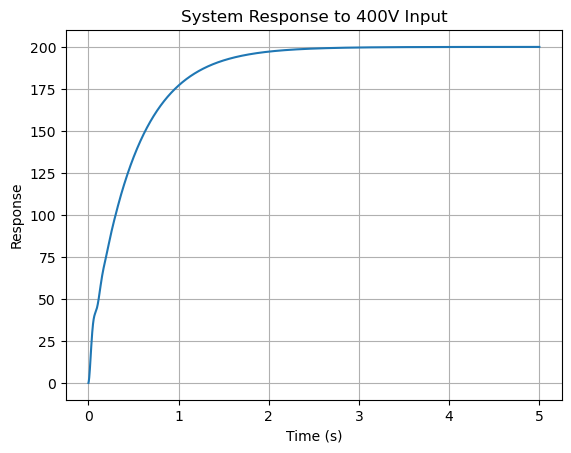

In [51]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

# Define the sampling time
T = 0.00175

# Define the transfer functions
num_gpz = [0.0058540, 0, 0]
den_gpz = [1, -1.9224928, 0.9337476]

gpz = ctrl.TransferFunction(num_gpz, den_gpz, T)
gpi = 0.15 * ctrl.TransferFunction([1, -0.95], [1, -1], T)
# gpid = 1 * ctrl.TransferFunction([1, -0.2], [1, -0.1], T)

# Compute the closed-loop transfer function
sys_open_loop = ctrl.series(gpz, gpi)  # C(s) * G(s)
sys_closed_loop = ctrl.feedback(sys_open_loop, 1)

# Root locus plot
# Simulate system response to a 400V input and 0 load
time = np.arange(0, 5, T)
T_out, yout = ctrl.forced_response(sys_closed_loop, T=time, U=np.ones_like(time)*200)

# Plot the response
plt.figure()
plt.plot(T_out, yout)
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title('System Response to 400V Input')
plt.grid()
plt.show()

/Users/lpds/anaconda3/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


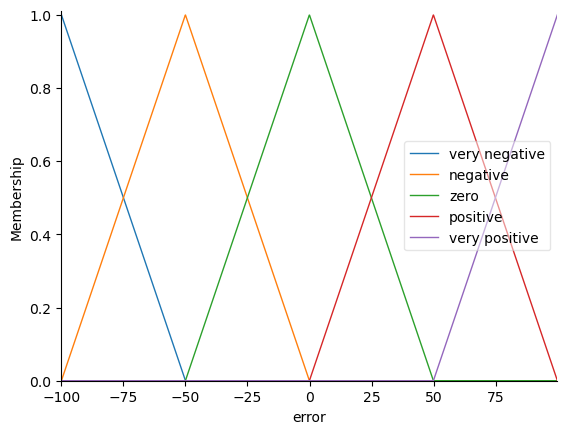

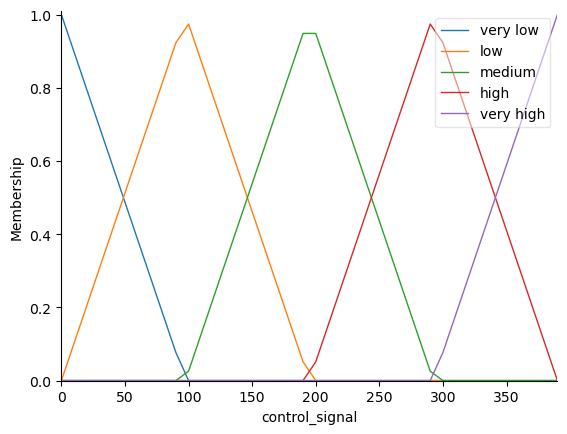

In [60]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrlf

# Define the sampling time
T = 0.00175

# Define the transfer function for the plant (gpz)
num_gpz = [0.0058540, 0, 0]
den_gpz = [1, -1.9224928, 0.9337476]
gpz = ctrl.TransferFunction(num_gpz, den_gpz, T)

# ================================================
# Fuzzy Logic Controller Design
# ================================================

# Define the input and output variables
error = ctrlf.Antecedent(np.arange(-100, 100, 0.1), "error")
control_signal = ctrlf.Consequent(np.arange(0, 400, 10), "control_signal")

# Define membership functions for the input (error)
# error['negative'] = fuzz.trimf(error.universe, [-10, -10, 0])
# error['zero'] = fuzz.trimf(error.universe, [-10, 0, 10])
# error['positive'] = fuzz.trimf(error.universe, [0, 10, 10])
error.automf(names=["very negative", "negative", "zero", "positive", "very positive"])

# Define membership functions for the output (control_signal)
# control_signal['low'] = fuzz.trimf(control_signal.universe, [-1, -1, 0])
# control_signal['medium'] = fuzz.trimf(control_signal.universe, [-1, 0, 1])
# control_signal['high'] = fuzz.trimf(control_signal.universe, [0, 1, 1])
control_signal.automf(names=["very low", "low", "medium", "high", "very high"])

# Define fuzzy rules
rules = [
    ctrlf.Rule(error["very negative"], control_signal["very low"]),
    ctrlf.Rule(error["negative"], control_signal["low"]),
    ctrlf.Rule(error["zero"], control_signal["medium"]),
    ctrlf.Rule(error["positive"], control_signal["high"]),
    ctrlf.Rule(error["very positive"], control_signal["very high"])
  
]

# Create the fuzzy control system
fuzzy_ctrl = ctrlf.ControlSystem(rules)
fuzzy_sim = ctrlf.ControlSystemSimulation(fuzzy_ctrl)

error.view()
control_signal.view()

# fuzzy_sim.input["error"] = -400
# fuzzy_sim.view(sim="negative")

400 - 357.37532808398953
397.90792482939634 - 357.37532808398953
397.92990971569134 - 357.37532808398953
397.92967868421016 - 357.37532808398953
397.9296811120392 - 357.37532808398953
397.929681086526 - 357.37532808398953
397.9296810867941 - 357.37532808398953
397.9296810867913 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 -

/Users/lpds/anaconda3/lib/python3.11/site-packages/control/timeresp.py:1089: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953
397.92968108679133 - 357.37532808398953


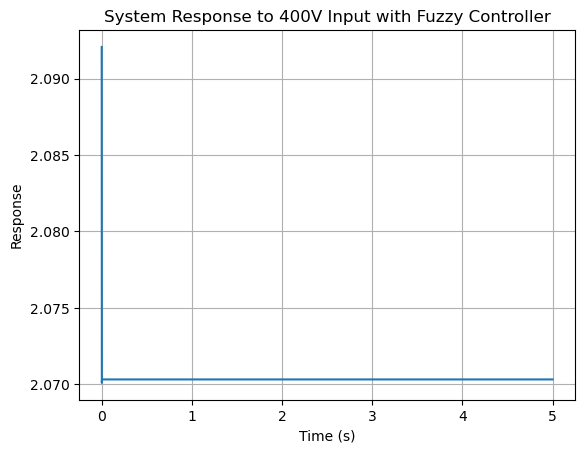

In [71]:

# ================================================
# Simulation Loop with Fuzzy Controller
# ================================================

# Time vector
time = np.arange(0, 5, T)
yout = np.zeros_like(time)
setpoint = 400  # Desired setpoint (400V)

# Initialize system state
error_prev = 0
output_prev = 0

# Simulate the system
for i, t in enumerate(time):
    # Compute the error
    error_current = setpoint - output_prev

    # Set the input to the fuzzy controller
    fuzzy_sim.input['error'] = error_current

    # Compute the fuzzy control signal
    fuzzy_sim.compute()

    # Get the control signal from the fuzzy controller
    control_signal_current = fuzzy_sim.output['control_signal']

    print(error_current, "-", control_signal_current)

    # Simulate the plant (gpz) with the control signal
    # Ensure U is a 1D array with the correct length
    U = control_signal_current
    _, y = ctrl.forced_response(gpz, T=[0, T], U=[0, U], X0=[0, output_prev])
    output_prev = y[-1]  # Update the output

    # Store the output
    yout[i] = output_prev

# Plot the response
plt.figure()
plt.plot(time, yout)
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.title('System Response to 400V Input with Fuzzy Controller')
plt.grid()
plt.show()